# **Clasificación de grafos con redes neuronales de grafos**

Vamos a  aplicar las redes neuronales de grafos (GNN) a la tarea de clasificación de grafos.
La clasificación de grafos se refiere al problema de clasificar **grafos completos** (en contraste con los nodos), dado un conjunto de datos de grafos, en función de algunas propiedades estructurales de los grafos.

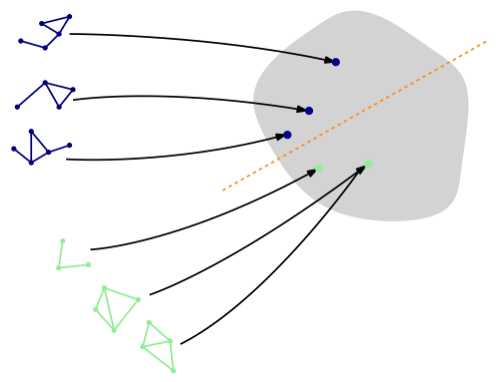


Un ejemplo común de clasificación a nivel de grafos es la predicción de propiedades moleculares, en la que las moléculas se representan como grafos y la tarea puede ser inferir si una molécula inhibe o no alguna proteína.

Hay una amplia gama de conjuntos de datos de clasificación de grafos, conocidos como TUDatasets, recopilados y a los que también se puede acceder a través de torch_geometric.datasets.TUDataset en PyTorch Geometric.
En este caso, inspeccionemos uno de los más pequeños: el conjunto de datos MUTAG:

In [1]:
!pip install -q torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00


In [2]:
#@title # Llamamos módulos necesarior y descargamos el dataset
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

Processing...
Done!


In [3]:
#@title Observamos algunas propieadades generales de la red
print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2


Este conjunto de datos proporciona **188 grafos diferentes, contiene 7 features y 2 clases**. La tarea es clasificar cada grafo en una de dos clases.

In [4]:
data = dataset[0]  # Llamamos al primer grafo del dataset para inspeccionarlo

In [5]:
print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Data(edge_index=[2, 38], x=[17, 7], edge_attr=[38, 4], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Al inspeccionar el primer objeto gráfico del conjunto de datos, vemos que tiene 17 nodos (con vectores de características de 7 dimensiones) y 38 aristas, lo que da como resultado un grado de nodo promedio de 2,24.

También incluye una etiqueta de gráfico (`y=[1]`), y además de los conjuntos de datos anteriores, proporciona características de aristas de cuatro dimensiones adicionales (`edge_attr=[38, 4]`).
Sin embargo, por simplicidad, no haremos uso de ellas.

PyTorch Geometric proporciona algunas utilidades útiles para trabajar con conjuntos de datos gráficos, *por ejemplo*, podemos mezclar el conjunto de datos y usar los primeros 150 gráficos como gráficos de entrenamiento, mientras usamos los restantes para pruebas:

In [6]:
torch.manual_seed(12345) # Seteamos una semilla
dataset = dataset.shuffle() # Realizamos una mezcla del dataset

split = round(len(dataset) * 0.8) # uso el 80% del dataset para entrenar
print(f'split: {split}')

train_dataset = dataset[:split]  # Definimos el dataset de entrenamiento
test_dataset = dataset[split:]  # definimos el dataset de test

print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')

split: 150
Number of training graphs: 150
Number of test graphs: 38


## Mini-batching

Dado que los gráficos de los conjuntos de datos de clasificación suelen ser pequeños, es una buena idea agruparlos antes de introducirlos en una red neuronal de grafos para garantizar el uso completo de la GPU.

En el ámbito de las imágenes o el lenguaje, este procedimiento se logra normalmente reescalando o rellenando (padding) cada ejemplo de un conjunto de formas del mismo tamaño y agrupándolos después en una dimensión adicional.
La longitud de esta dimensión es entonces igual al número de ejemplos agrupados en un minilote y normalmente se denomina `batch_size`.

PyTorch Geometric en busca de optimizar los procesos opta por lograr la paralelización mediante que las matrices de adyacencia se apilan en forma diagonal (lo que crea un gráfico gigante que contiene múltiples subgráficos aislados) y las características de nodo y destino simplemente se concatenan en la dimensión del nodo.

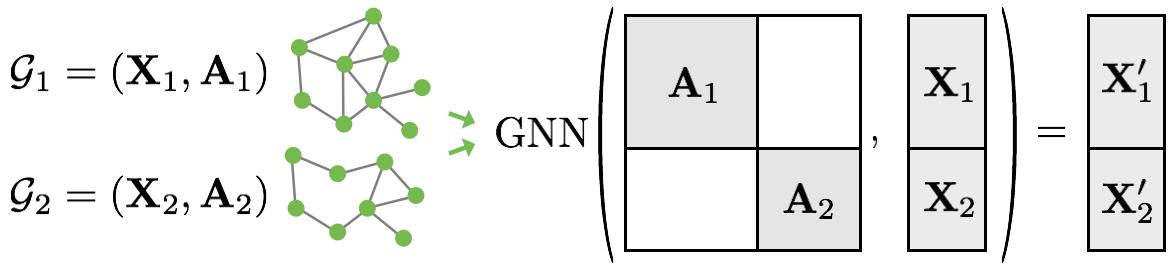

Este procedimiento tiene algunas ventajas cruciales con respecto a otros procedimientos de procesamiento por lotes:

1. Los operadores GNN que dependen de un esquema de paso de mensajes que no necesitan ser modificados, ya que los mensajes no se intercambian entre dos nodos de gráficos diferentes.

2. No hay sobrecarga computacional o de memoria, ya que las matrices de adyacencia se guardan de manera dispersa y solo contienen entradas distintas de cero, es decir, los bordes.

PyTorch Geometric se encarga automáticamente de **agrupar varios grafos en un único grafo gigante** con la ayuda de la clase [`torch_geometric.data.DataLoader`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.DataLoader):

In [7]:
from torch_geometric.loader import DataLoader

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) # Crea un dataloader con un batch size de 64 grafos. Además los mezcla
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # Crea un dataloader con un batch size de 64 grafos. Además los mezcla

for step, data in enumerate(train_loader): # Enseña como quedó conformado los dataloaders
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2636], x=[1188, 7], edge_attr=[2636, 4], y=[64], batch=[1188], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(edge_index=[2, 2506], x=[1139, 7], edge_attr=[2506, 4], y=[64], batch=[1139], ptr=[65])

Step 3:
Number of graphs in the current batch: 22
DataBatch(edge_index=[2, 852], x=[387, 7], edge_attr=[852, 4], y=[22], batch=[387], ptr=[23])



En este caso, hemos optado por un batch_size de 64, lo que da como resultado 3 mini_batchs (reorganizados aleatoriamente) que contienen los $2·64+22=150$ gráficos.

Además, cada objeto Batch está equipado con un vector batch que asigna cada nodo a su gráfico respectivo en el lote:

$$
\textrm{batch} = [ 0, \ldots, 0, 1, \ldots, 1, 2, \ldots ]
$$



## Entrenando la Graph Neural Network (GNN)

In [8]:
#@title # llamamos los modulos necesarios
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


## **Modelo 1**

In [9]:
class GCN_1(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345) # Seteanis yba semilla
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels) # capa 1
        self.conv2 = GCNConv(hidden_channels, hidden_channels)  # capa 2
        self.conv3 = GCNConv(hidden_channels, hidden_channels)  # capa 3
        self.lin = Linear(hidden_channels, dataset.num_classes)  # capa lineal (salida)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()  # Función de activación
        x = self.conv2(x, edge_index)
        x = x.relu()  # Función de activación
        x = self.conv3(x, edge_index)

        # Capa Readout
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x) # Clasificador final

        return x



In [10]:
#@title # Apreciamos la arquitectura de la red
model = GCN_1(hidden_channels=64)
print(model)

GCN_1(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [11]:
#@title # Definimos una función de entrenamiento
def train(models,loader):
    models.train() # Ponemos el modelo en modo entrenamiento
    for data in loader:  # Itera sobre los trainloaders
         out = models(data.x, data.edge_index, data.batch)  # realiza una predicción
         loss = criterion(out, data.y)  # calcula la pérdida
         loss.backward()  # Deriva gradientes.
         optimizer.step()  # Actualiza los parámetros en base a los gradientes
         optimizer.zero_grad()  # Se limpian los gradientes
         return loss

In [12]:
#@title # Definimos una función de test
def test(models, loader):
    models.eval()  # Ponemos el modelo en modo de evaluación
    correct = 0
    total_samples = 0  # Inicializar el contador para el número total de muestras en el conjunto de pruebas

    for data in loader:  # Iterar sobre los datos del test_loader
        out = models(data.x, data.edge_index, data.batch)  # Realizar una predicción
        pred = out.argmax(dim=1)  # Obtener la clase predicha con mayor probabilidad
        loss = criterion(out, data.y)  # Calcular la pérdida
        correct += int((pred == data.y).sum())
        total_samples += data.y.size(0)  # Incrementar el contador con el tamaño del lote actual

    acc = correct / total_samples  # Calcular el accuracy dividiendo los aciertos totales por el número total de muestras

    return loss, acc

In [13]:
#@title # Creamos el modelo
model_1 = GCN_1(hidden_channels=64)

In [14]:
#@title # Definimos el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model_1.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

In [15]:
#@title # Performance del modelo sin entrenar
loss,acc = test(model_1,test_loader)
print(f'{acc*100:.2f}%')

55.26%


In [16]:
#@title # Entrenamos
loss_train = []
loss_test = []
epochs = []
for epoch in range(1, 101): # Entreno po X epochs
    loss_training = train(model_1,train_loader)
    loss_train.append(float(loss_training))
    loss_testing,acc = test(model_1,test_loader)
    loss_test.append(float(loss_testing))
    epochs.append(epoch)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d}, Loss_Train: {loss_training:.4f}, Loss_Test: {loss_testing:.4f}, Accuracy: {acc:.4f}')

Epoch: 010, Loss_Train: 0.6325, Loss_Test: 0.5561, Accuracy: 0.7368
Epoch: 020, Loss_Train: 0.5192, Loss_Test: 0.4495, Accuracy: 0.7632
Epoch: 030, Loss_Train: 0.5349, Loss_Test: 0.4394, Accuracy: 0.7632
Epoch: 040, Loss_Train: 0.5927, Loss_Test: 0.4717, Accuracy: 0.7895
Epoch: 050, Loss_Train: 0.5798, Loss_Test: 0.4507, Accuracy: 0.7895
Epoch: 060, Loss_Train: 0.5203, Loss_Test: 0.4807, Accuracy: 0.7895
Epoch: 070, Loss_Train: 0.5137, Loss_Test: 0.4363, Accuracy: 0.7632
Epoch: 080, Loss_Train: 0.4510, Loss_Test: 0.4517, Accuracy: 0.7632
Epoch: 090, Loss_Train: 0.5163, Loss_Test: 0.4651, Accuracy: 0.7632
Epoch: 100, Loss_Train: 0.5092, Loss_Test: 0.4443, Accuracy: 0.7632


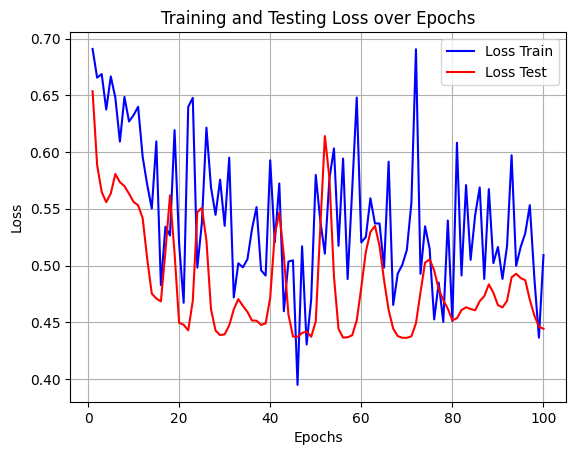

In [17]:
import matplotlib.pyplot as plt

# Crear la gráfica
plt.figure()
plt.plot(epochs, loss_train, label='Loss Train', color='blue')
plt.plot(epochs, loss_test, label='Loss Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [18]:
model_1.eval()
loss,acc = test(model_1,test_loader)
print(f'{acc*100:.2f}%')

76.32%


## **Curva ROC (Receiver operating characteristic)**
Una curva característica operativa del receptor, también llamada curva ROC, es un gráfico que ilustra el rendimiento de un modelo de clasificador binario (también se puede utilizar para la clasificación de múltiples clases) en distintos valores de umbral.

La curva ROC es el gráfico de la tasa de verdaderos positivos (TPR) frente a la tasa de falsos positivos (FPR) para cada valor del umbral.

El AUC (Área Bajo la Curva) es una métrica que se utiliza para medir el rendimiento de un modelo de aprendizaje automático


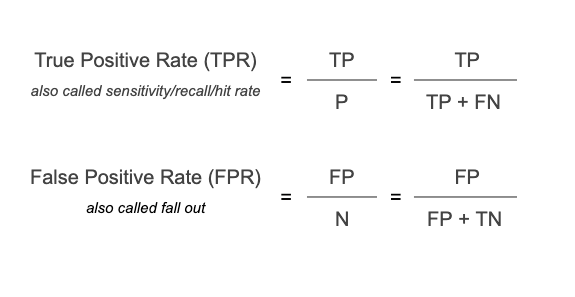

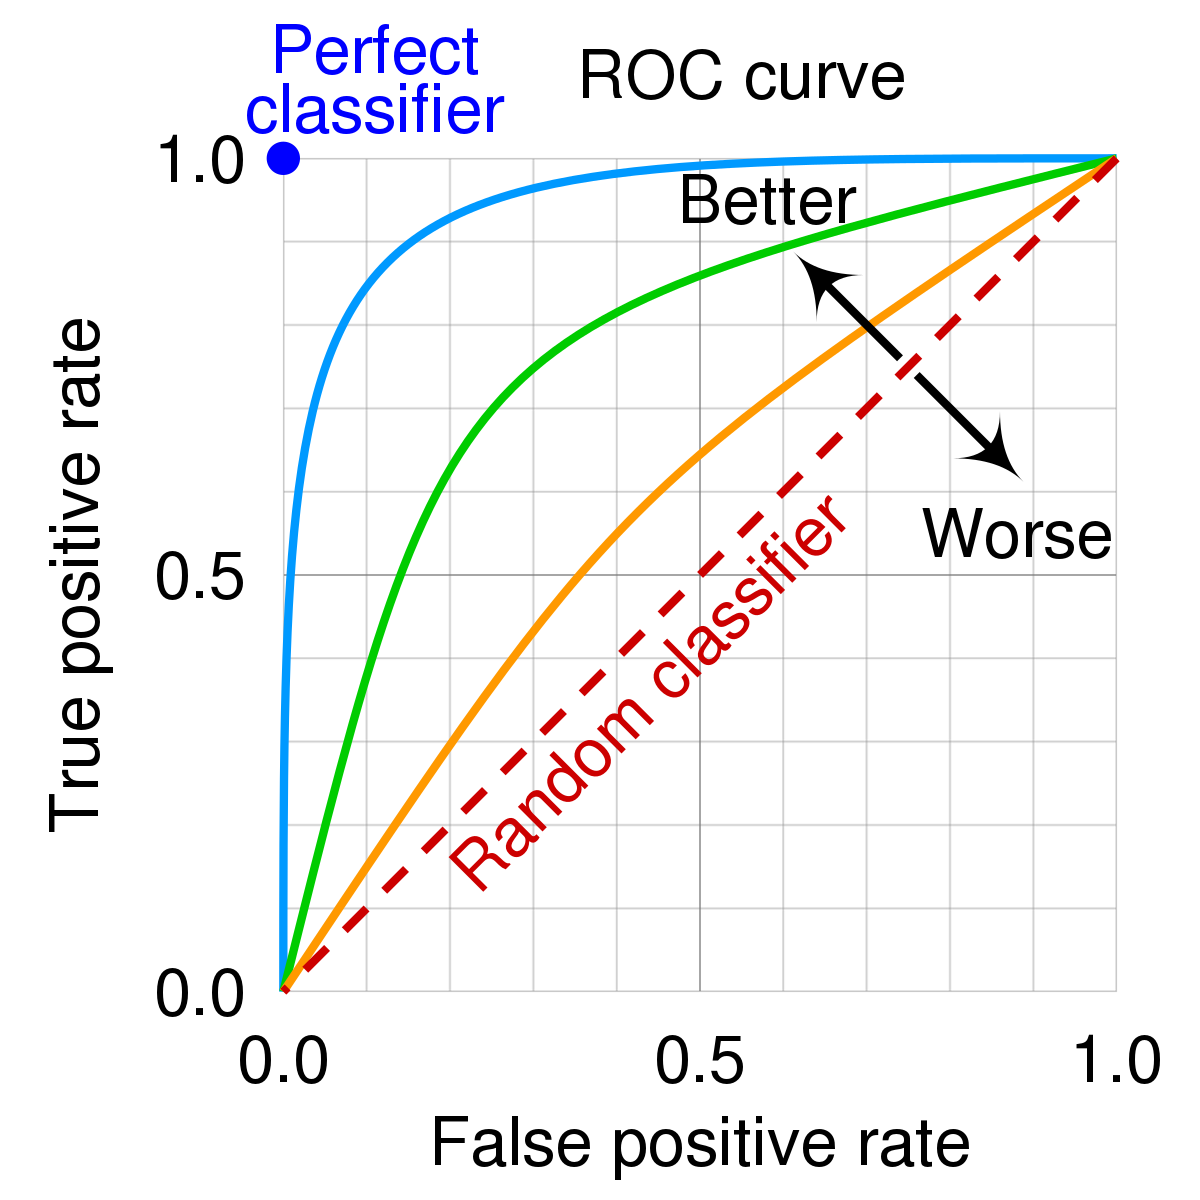

In [19]:
#@title # Módulos necesarios
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [20]:
def test_roc(models, loader):
    models.eval()  # Ponemos el modelo en modo de evaluación
    predictions = []
    targets = []

    for data in loader:  # Iterar sobre los datos del test_loader
        out = models(data.x, data.edge_index, data.batch)  # Realizar una predicción
        predictions.extend(out[:, 1].detach().numpy())  # Asumiendo que las probabilidades de la clase positiva están en la segunda columna
        targets.extend(data.y.detach().numpy())

    return predictions, targets

In [21]:
predictions, targets = test_roc(model_1, test_loader)

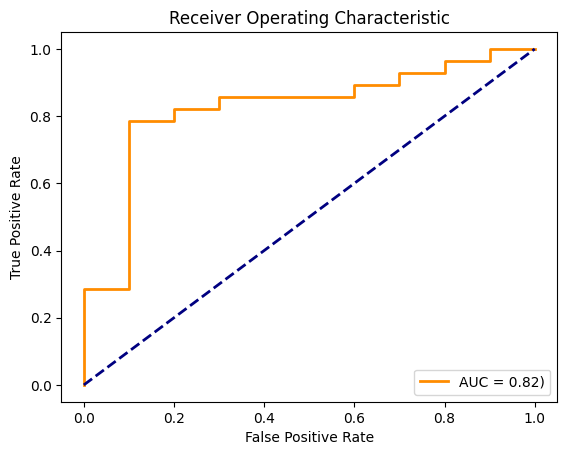

In [22]:
fpr, tpr, thresholds = roc_curve(targets, predictions)
roc_auc = roc_auc_score(targets, predictions)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

## **Modelo 2**

Probemos un modelo con una capa menos

In [23]:
class GCN_2(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345) # Seteanis yba semilla
        self.conv1 = GCNConv(dataset.num_node_features, hidden_channels) # capa 1
        self.conv2 = GCNConv(hidden_channels, hidden_channels)  # capa 2
        self.lin = Linear(hidden_channels, dataset.num_classes)  # capa lineal (salida)

    def forward(self, x, edge_index, batch):
        x = self.conv1(x, edge_index)
        x = x.relu()  # Función de activación
        x = self.conv2(x, edge_index)

        # Capa Readout
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x) # Clasificador final

        return x


In [24]:
#@title # Creamos el modelo
model_2 = GCN_2(hidden_channels=64)
print(model_2)

GCN_2(
  (conv1): GCNConv(7, 64)
  (conv2): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [25]:
#@title # Performance del modelo sin entrenar
loss,acc = test(model_2,test_loader)
print(f'{acc*100:.2f}%')

73.68%


In [26]:
#@title # Definimos el optimizador y la función de pérdida
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.01) # Revisar si dice el nombre de nuestro modelo
criterion = torch.nn.CrossEntropyLoss()

In [27]:
#@title # Entrenamos
loss_train = []
loss_test = []
epochs = []
for epoch in range(1, 101): # Entreno po X epochs
    loss_training = train(model_2,train_loader)
    loss_train.append(float(loss_training))
    loss_testing,acc = test(model_2,test_loader)
    loss_test.append(float(loss_testing))
    epochs.append(epoch)
    if epoch % 10 == 0:
      print(f'Epoch: {epoch:03d}, Loss_Train: {loss_training:.4f}, Loss_Test: {loss_testing:.4f}, Accuracy: {acc:.4f}')

Epoch: 010, Loss_Train: 0.6398, Loss_Test: 0.5927, Accuracy: 0.7368
Epoch: 020, Loss_Train: 0.6271, Loss_Test: 0.5123, Accuracy: 0.7368
Epoch: 030, Loss_Train: 0.4796, Loss_Test: 0.4596, Accuracy: 0.7632
Epoch: 040, Loss_Train: 0.4796, Loss_Test: 0.5110, Accuracy: 0.7632
Epoch: 050, Loss_Train: 0.6610, Loss_Test: 0.4871, Accuracy: 0.7895
Epoch: 060, Loss_Train: 0.5367, Loss_Test: 0.4468, Accuracy: 0.7632
Epoch: 070, Loss_Train: 0.5027, Loss_Test: 0.4571, Accuracy: 0.7632
Epoch: 080, Loss_Train: 0.5222, Loss_Test: 0.4854, Accuracy: 0.7895
Epoch: 090, Loss_Train: 0.5141, Loss_Test: 0.5232, Accuracy: 0.8158
Epoch: 100, Loss_Train: 0.5214, Loss_Test: 0.4949, Accuracy: 0.7632


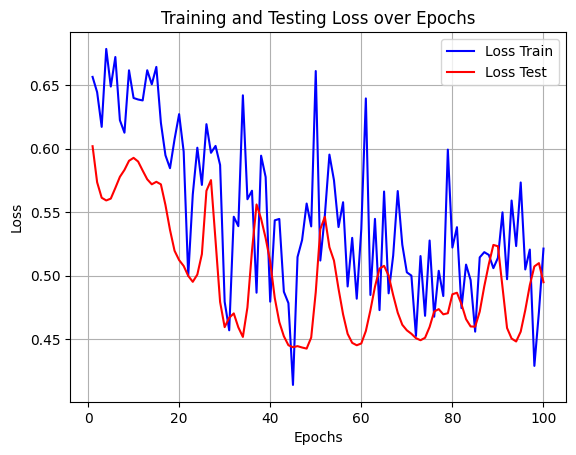

In [28]:
import matplotlib.pyplot as plt

# Crear la gráfica
plt.figure()
plt.plot(epochs, loss_train, label='Loss Train', color='blue')
plt.plot(epochs, loss_test, label='Loss Test', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Testing Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()


In [29]:
model_2.eval()
loss,acc = test(model_2,test_loader)
print(f'{acc*100:.2f}%')

76.32%


## **Curva ROC**

In [30]:
#@title # Módulos necesarios
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

In [31]:
predictions, targets = test_roc(model_2, test_loader)

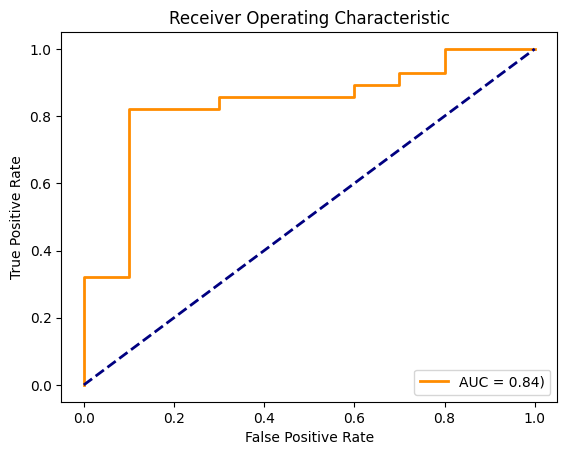

In [32]:
fpr, tpr, thresholds = roc_curve(targets, predictions)
roc_auc = roc_auc_score(targets, predictions)

# Graficar la curva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# **Actividades**


#*   Variar el número de epocas buscando obtener el mejor resultado
#*   Intentar entrenar la red con otro optimizador. Modificar el learning rate
#*   Modificar el tamaño del split del entrenamiento. Probar por ejemplo 70-30, 60-40, etc.
#*  Utilizar otra función de activación
#*  Modificar el número de capas

